# Gaussian - Prewitt - Median - Threshold

In [67]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

In [68]:
# fungsi untuk crop citra ke ukuran 1 banding 1
def crop_to_1by1(citra_input):
    tinggi, panjang = citra_input.shape[:2]

    if(panjang == tinggi):
        print(f"{tinggi} == {panjang}\n tidak perlu crop ke 1:1")
        return citra_input

    if panjang < tinggi:
        terpendek = panjang
    elif panjang > tinggi:
        terpendek = tinggi

    hasil = np.zeros((terpendek, terpendek), dtype=citra_input.dtype)

    if panjang > tinggi:
        offset = (panjang - terpendek) // 2
        for i in range(terpendek):
            for j in range(terpendek):
                hasil[i, j] = citra_input[i, j + offset]
    else:
        offset = (tinggi - terpendek) // 2
        for i in range(terpendek):
            for j in range(terpendek):
                hasil[i, j] = citra_input[i + offset, j]

    return hasil

In [69]:
# fungsi untuk resize citra agar semuanya memiliki ukuran yang sama
def resize(citra_input, tinggi_baru, panjang_baru):
    tinggi, panjang = citra_input.shape[:2]
    resized_citra = np.zeros((tinggi_baru, panjang_baru), dtype=citra_input.dtype)

    y_ratio = tinggi / tinggi_baru
    x_ratio = panjang / panjang_baru

    for i in range(tinggi_baru):
        for j in range(panjang_baru):
            src_y = int(i * y_ratio)
            src_x = int(j * x_ratio)
            resized_citra[i, j] = citra_input[src_y, src_x]

    return resized_citra

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [70]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = crop_to_1by1(img)
        img = resize(img, 140, 140)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

600 == 600
 tidak perlu crop ke 1:1
600 == 600
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1


## Data Understanding

In [71]:
# -----------------------------
# 1. Menampilkan Jumlah Data
print("Jumlah total gambar:", len(data))
print("Jumlah kelas:", len(np.unique(labels)))
print("Distribusi per kelas:", Counter(labels))

Jumlah total gambar: 200
Jumlah kelas: 2
Distribusi per kelas: Counter({np.str_('Clean'): 100, np.str_('Dirty'): 100})


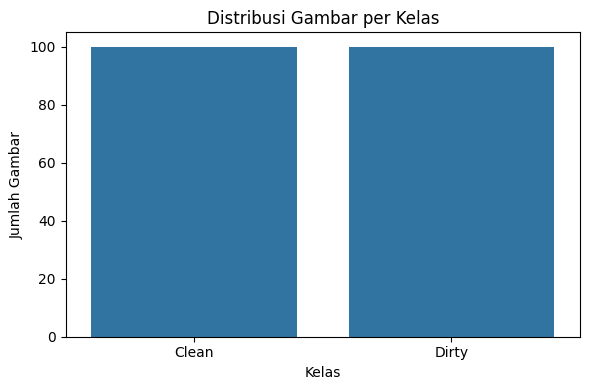

In [72]:
# -----------------------------
# 2. Visualisasi Distribusi Data
label_df = pd.DataFrame({'Label': labels})
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=label_df)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

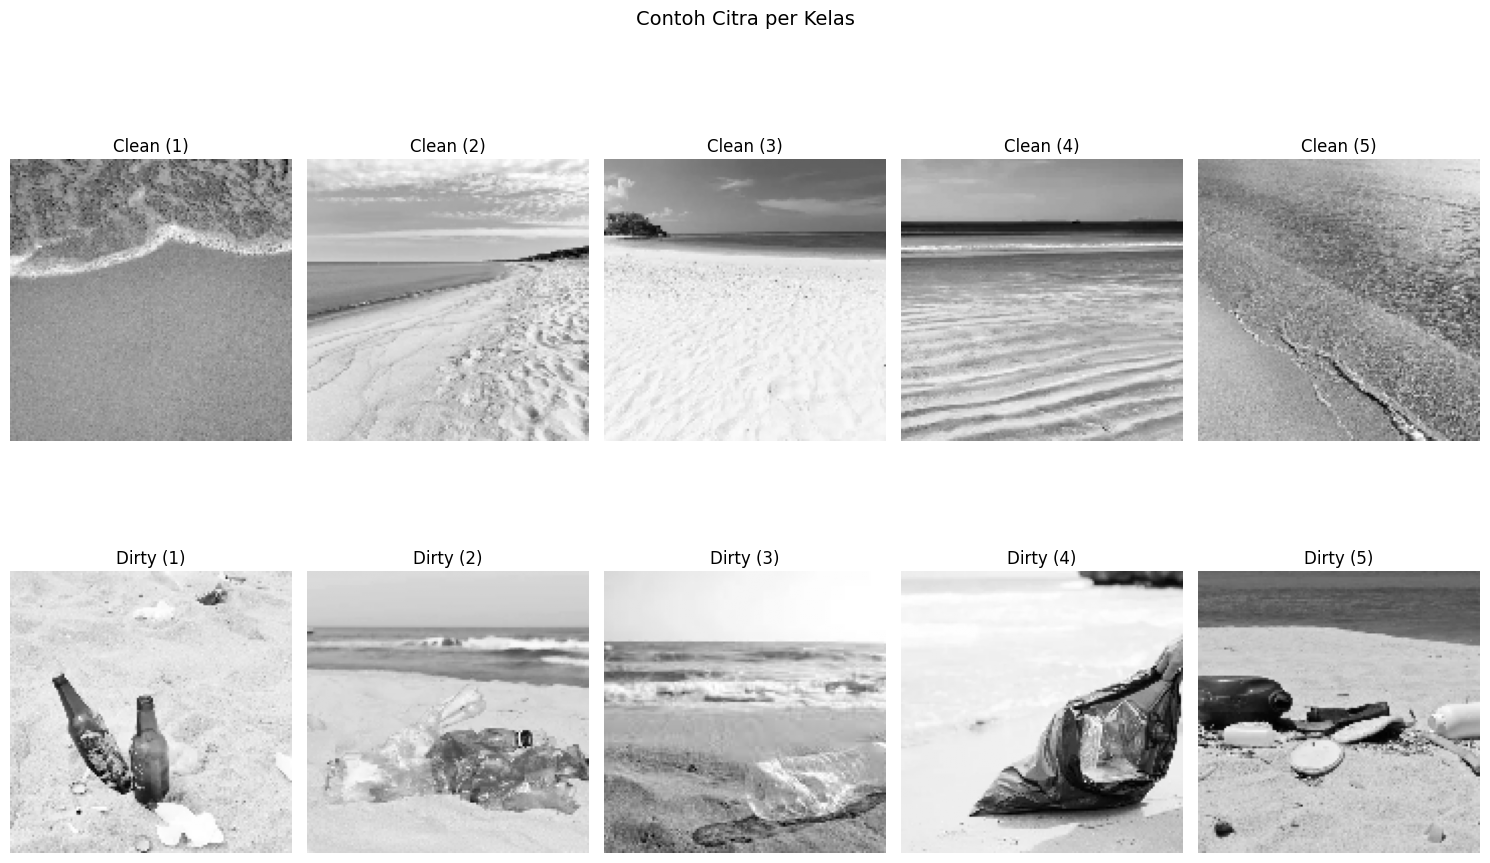

In [73]:
# -----------------------------
# 3. Menampilkan Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 10))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(data[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas", fontsize=14)
plt.tight_layout()
plt.show()

In [74]:
# label_target = 'Dirty'  # Ganti ke 'Clean' jika ingin label lain

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(data[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' sebelum Preprocessing", fontsize=14)
# plt.show()

In [75]:
# label_target = 'Clean'

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(data[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' sebelum Preprocessing", fontsize=14)
# plt.show()

## Data Augmentation

### Define Augmentation Function


In [76]:
def horizontal_flip(img):
    tinggi, panjang = img.shape[:2]
    flipped = [[img[i][-j - 1] for j in range(panjang)] for i in range(tinggi)]
    return np.array(flipped, dtype=np.uint8)

In [77]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []

for i in range(len(data)):
    original_img = data[i]
    label = labels[i]
    fname = file_name[i]

    flipped_img = horizontal_flip(original_img)

    data_augmented.append(flipped_img)
    labels_augmented.append(label)
    file_name_augmented.append(f"{fname}_flipped")
    paths_augmented.append(f"augmented/{fname}_flipped.png")

# konversi ke array numpy
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)


In [78]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  200


## Data Preparation

### Define Preprocessing Function

In [79]:
# edge padding 1 px ke semua sisi
def edge_padding_1px(input_citra):
    tinggi_input, panjang_input = input_citra.shape[:2]

    tinggi_output = tinggi_input+2
    panjang_output = panjang_input+2

    output = np.zeros((tinggi_output, panjang_output), dtype=input_citra.dtype)

    # Salin bagian tengah
    output[1:-1, 1:-1] = input_citra

    # Padding baris atas dan bawah
    output[0, 1:-1] = input_citra[0, :]
    output[-1, 1:-1] = input_citra[-1, :]

    # Padding kolom kiri dan kanan
    output[1:-1, 0] = input_citra[:, 0]
    output[1:-1, -1] = input_citra[:, -1]

    # Sudut-sudut
    output[0, 0] = input_citra[0, 0]
    output[0, -1] = input_citra[0, -1]
    output[-1, 0] = input_citra[-1, 0]
    output[-1, -1] = input_citra[-1, -1]

    return output

# untuk geser kernel di atas citra
def konvolusi_3x3(citra_input, jenis_kernel): # untuk padded 1px
    tinggi, panjang = citra_input.shape[:2]

    tinggi_hasil = tinggi-2 # kurangin padding tadi
    panjang_hasil = panjang-2

    hasil = np.zeros((tinggi_hasil, panjang_hasil), dtype=np.float32)

    for i in range(0, tinggi_hasil):
        for j in range(0, panjang_hasil):
            sum_jendela = 0
            for k in range(i, i+3): # 3x3
                for l in range(j, j+3):
                    sum_jendela += float(citra_input[k, l]) * jenis_kernel[k-i, l-j]
            hasil[i, j] = sum_jendela 

    return hasil

# definisi kernel  yang akan digunakan
kernel_gaussian = np.array([[1/16, 2/16, 1/16],
                            [2/16, 4/16, 2/16],
                            [1/16, 2/16, 1/16]])

# untuk apply kernel
def apply_kernel(img, kernel):
    img_padded = edge_padding_1px(img)
    img_filtered = konvolusi_3x3(img_padded, kernel)
    return img_filtered

In [80]:
# definisi kernel prewitt
kernel_prewitt_Gx = np.array([[-1, 0, +1],
                              [-1, 0, +1],
                              [-1, 0, +1]])

kernel_prewitt_Gy = np.array([[+1, +1, +1],
                              [ 0,  0,  0],
                              [-1, -1, -1]])

# untuk menghitung G
def magnitudo_gradien(Gx, Gy):
    Gx = Gx.astype(np.float32)
    Gy = Gy.astype(np.float32)

    tinggi, panjang = Gx.shape[:2]
    G = np.zeros((tinggi, panjang), dtype=np.float32)

    for i in range(tinggi):
        for j in range(panjang):
            G[i, j] = (Gx[i, j]**2 + Gy[i, j]**2)**0.5

    return G

# untuk deteksi tepi
def edge_detection(img, kernel_Gx, kernel_Gy):
    img_padded = edge_padding_1px(img) # tambahkan padding

    Gx = konvolusi_3x3(img_padded, kernel_Gx)
    Gy = konvolusi_3x3(img_padded, kernel_Gy)
    G = magnitudo_gradien(Gx, Gy)

    return G

# untuk normalisasi dan mengembalikan float32 ke uint8
def G_normalized(G):
    G_max = G.max()
    if G_max == 0:
        return np.zeros_like(G, dtype=np.uint8)
    return ((G / G_max) * 255).astype(np.uint8)

In [81]:
def filter_median_3x3(citra_input):
    tinggi, panjang = citra_input.shape[:2]

    tinggi_hasil = tinggi-2 # kurangin padding tadi
    panjang_hasil = panjang-2

    hasil = np.zeros((tinggi_hasil, panjang_hasil), dtype=citra_input.dtype)

    for i in range(tinggi_hasil):
        for j in range(panjang_hasil):
            arr_jendela = []
            for k in range(i, i+3):
                for l in range(j, j+3):
                    arr_jendela.append(citra_input[k, l])
            arr_jendela.sort()
            median = arr_jendela[4] 
            hasil[i, j] = median

    return hasil

In [82]:
def threshold_saja(image, batas):
    hasil = np.copy(image)
    hasil[hasil >= batas] = 255
    hasil[hasil < batas] = 0
    return hasil

### Preprocessing

In [83]:
# Gabungkan data dan label
data_combined = np.concatenate((data, data_augmented), axis=0)
labels_combined = np.concatenate((labels, labels_augmented), axis=0)

# Proses semua data yang sudah digabung
dataPreprocessed = []
for i in range(len(data_combined)):
    img = data_combined[i]
    img = apply_kernel(img, kernel_gaussian)
    img = edge_detection(img, kernel_prewitt_Gx, kernel_prewitt_Gy)
    img = G_normalized(img)
    img = filter_median_3x3(img)
    img = threshold_saja(img, 100)
    dataPreprocessed.append(img)

dataPreprocessed = np.array(dataPreprocessed)


In [84]:
print(len(data_combined))
file_name_combined = file_name + file_name_augmented  # hasilnya 400
print(len(file_name_combined))

400
400


In [85]:
## buat ngecek tipe datanya (siapa tau berubah)
print(type(img))           # Cek apakah ini NumPy array
print(img.dtype)           # Cek tipe data elemen (misal: uint8, float32, dll)
print(img.shape)           # Ukuran array (dimensi)

<class 'numpy.ndarray'>
uint8
(138, 138)


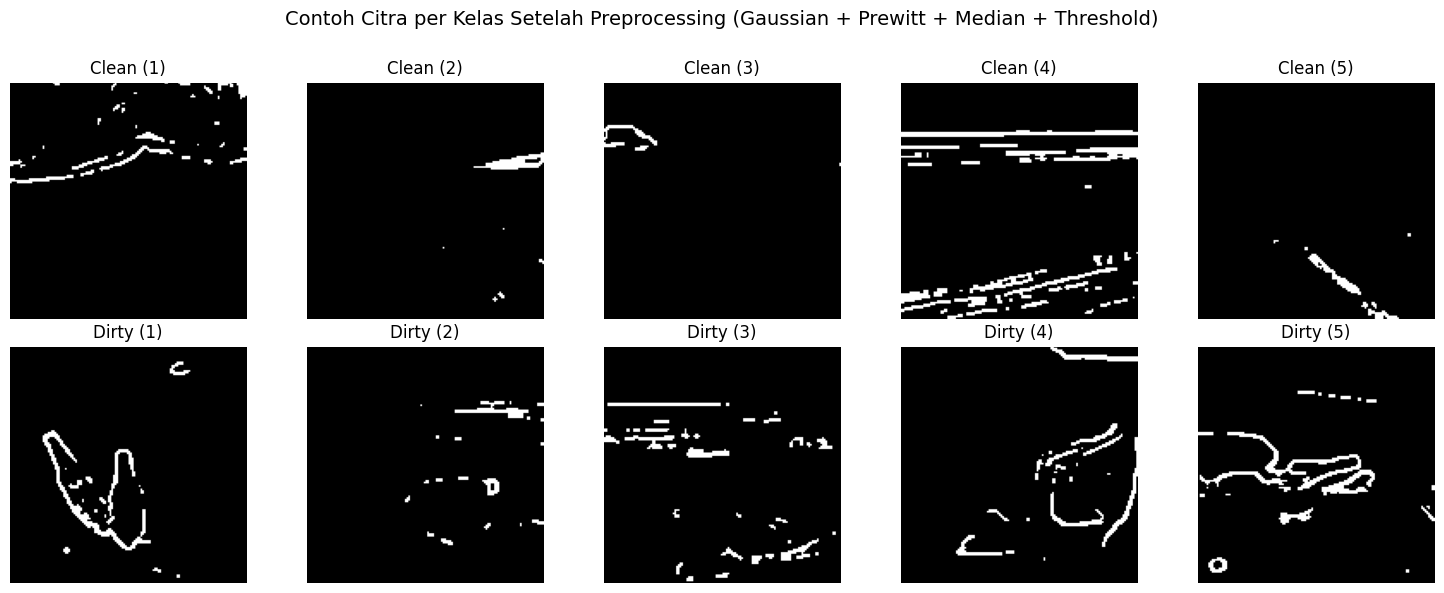

In [86]:
# Gunakan labels_combined karena dataPreprocessed berasal dari data_combined
unique_labels = np.unique(labels_combined)

plt.figure(figsize=(15, 3 * len(unique_labels)))  # Tinggi disesuaikan jumlah kelas

for i, label in enumerate(unique_labels):
    # Ambil indeks untuk label tersebut
    idxs = np.where(labels_combined == label)[0][:5]  # Ambil maksimal 5 indeks pertama

    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i * 5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label} ({j + 1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas Setelah Preprocessing (Gaussian + Prewitt + Median + Threshold)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Supaya title tidak terpotong
plt.show()


In [87]:
# label_target = 'Dirty'

# # Ambil indeks yang sesuai dengan label_target dari labels_combined
# idxs = np.where(labels_combined == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom per baris
# rows = (total_images + cols - 1) // cols  # Jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Ukuran gambar disesuaikan jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(dataPreprocessed[idx], cmap='gray')
#     plt.title(file_name_combined[idx])  # Gunakan nama file gabungan
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.97])  # Supaya suptitle tidak terpotong
# plt.suptitle(f"Seluruh Citra Label '{label_target}' Setelah Preprocessing (Gaussian + Prewitt + Median + Threshold)", fontsize=14)
# plt.show()


In [88]:
# label_target = 'Clean'

# # Ambil indeks yang sesuai dengan label_target dari labels_combined
# idxs = np.where(labels_combined == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom per baris
# rows = (total_images + cols - 1) // cols  # Jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Ukuran gambar disesuaikan jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(dataPreprocessed[idx], cmap='gray')
#     plt.title(file_name_combined[idx])  # Gunakan nama file gabungan
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.97])  # Supaya suptitle tidak terpotong
# plt.suptitle(f"Seluruh Citra Label '{label_target}' Setelah Preprocessing (Gaussian + Prewitt + Median + Threshold)", fontsize=14)
# plt.show()


### Feature Extraction

In [89]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [90]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [91]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [92]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [93]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [94]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [95]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [96]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [97]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [98]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [99]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [100]:
for i in range(len(data_combined)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [101]:
for i in range(len(data_combined)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [102]:
for i in range(len(data_combined)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [103]:
for i in range(len(data_combined)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [104]:
for i in range(len(data_combined)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [105]:
for i in range(len(data_combined)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [106]:
print("Filename:", len(file_name_combined))
print("Label:", len(labels_combined))
print("Contrast0:", len(Kontras0))
print("Homogeneity0:", len(homogenity0))
print("Dissimilarity0:", len(dissimilarity0))
print("Entropy0:", len(entropy0))
print("ASM0:", len(ASM0))
print("Energy0:", len(energy0))
print("Correlation0:", len(correlation0))
dataTable = {'Filename': file_name_combined, 'Label': labels_combined,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }

df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


Filename: 400
Label: 400
Contrast0: 400
Homogeneity0: 400
Dissimilarity0: 400
Entropy0: 400
ASM0: 400
Energy0: 400
Correlation0: 400


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,Clean,811.694700,1836.179338,1472.056490,1493.194896,0.987517,0.971762,0.977362,0.977037,...,0.925879,0.926057,0.967046,0.959741,0.962226,0.962319,0.762213,0.451224,0.564608,0.554168
1,10.jpg,Clean,144.454142,464.241569,426.483656,415.738718,0.997779,0.992861,0.993441,0.993607,...,0.970069,0.970479,0.987310,0.984756,0.984921,0.985129,0.903422,0.691842,0.719896,0.724038
2,100.jpg,Clean,161.651063,363.771378,364.574738,426.132186,0.997514,0.994406,0.994393,0.993447,...,0.980454,0.979891,0.991977,0.990373,0.990179,0.989894,0.815869,0.588623,0.598681,0.518102
3,11.jpg,Clean,1169.390670,5338.778038,4646.608220,4715.169961,0.982017,0.917898,0.928542,0.927488,...,0.766735,0.765868,0.903512,0.870495,0.875634,0.875139,0.891668,0.507999,0.571878,0.565468
4,12.jpg,Clean,350.817201,353.377910,405.847350,644.395013,0.994605,0.994566,0.993759,0.990090,...,0.970589,0.966812,0.985295,0.985504,0.985185,0.983266,0.773585,0.767520,0.731076,0.576067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,95.jpg_flipped,Dirty,1286.329737,2702.301668,2187.448429,2646.869839,0.980218,0.958443,0.966360,0.959295,...,0.875190,0.868396,0.942653,0.931458,0.935516,0.931878,0.785011,0.550995,0.635540,0.560206
396,96.jpg_flipped,Dirty,1403.268804,3305.122809,2909.719137,3492.205232,0.978420,0.949172,0.955253,0.946295,...,0.842628,0.834425,0.930005,0.914878,0.917948,0.913469,0.810658,0.557064,0.609621,0.531992
397,97.jpg_flipped,Dirty,1840.070613,3558.030529,3246.778800,4112.348820,0.971703,0.945283,0.950070,0.936758,...,0.823675,0.811596,0.918659,0.905050,0.907565,0.900886,0.779899,0.576359,0.612597,0.510358
398,98.jpg_flipped,Dirty,216.681212,280.623635,178.847985,266.765677,0.996668,0.995684,0.997250,0.995898,...,0.987258,0.985895,0.993344,0.992816,0.993609,0.992923,0.664992,0.569260,0.724934,0.590531


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

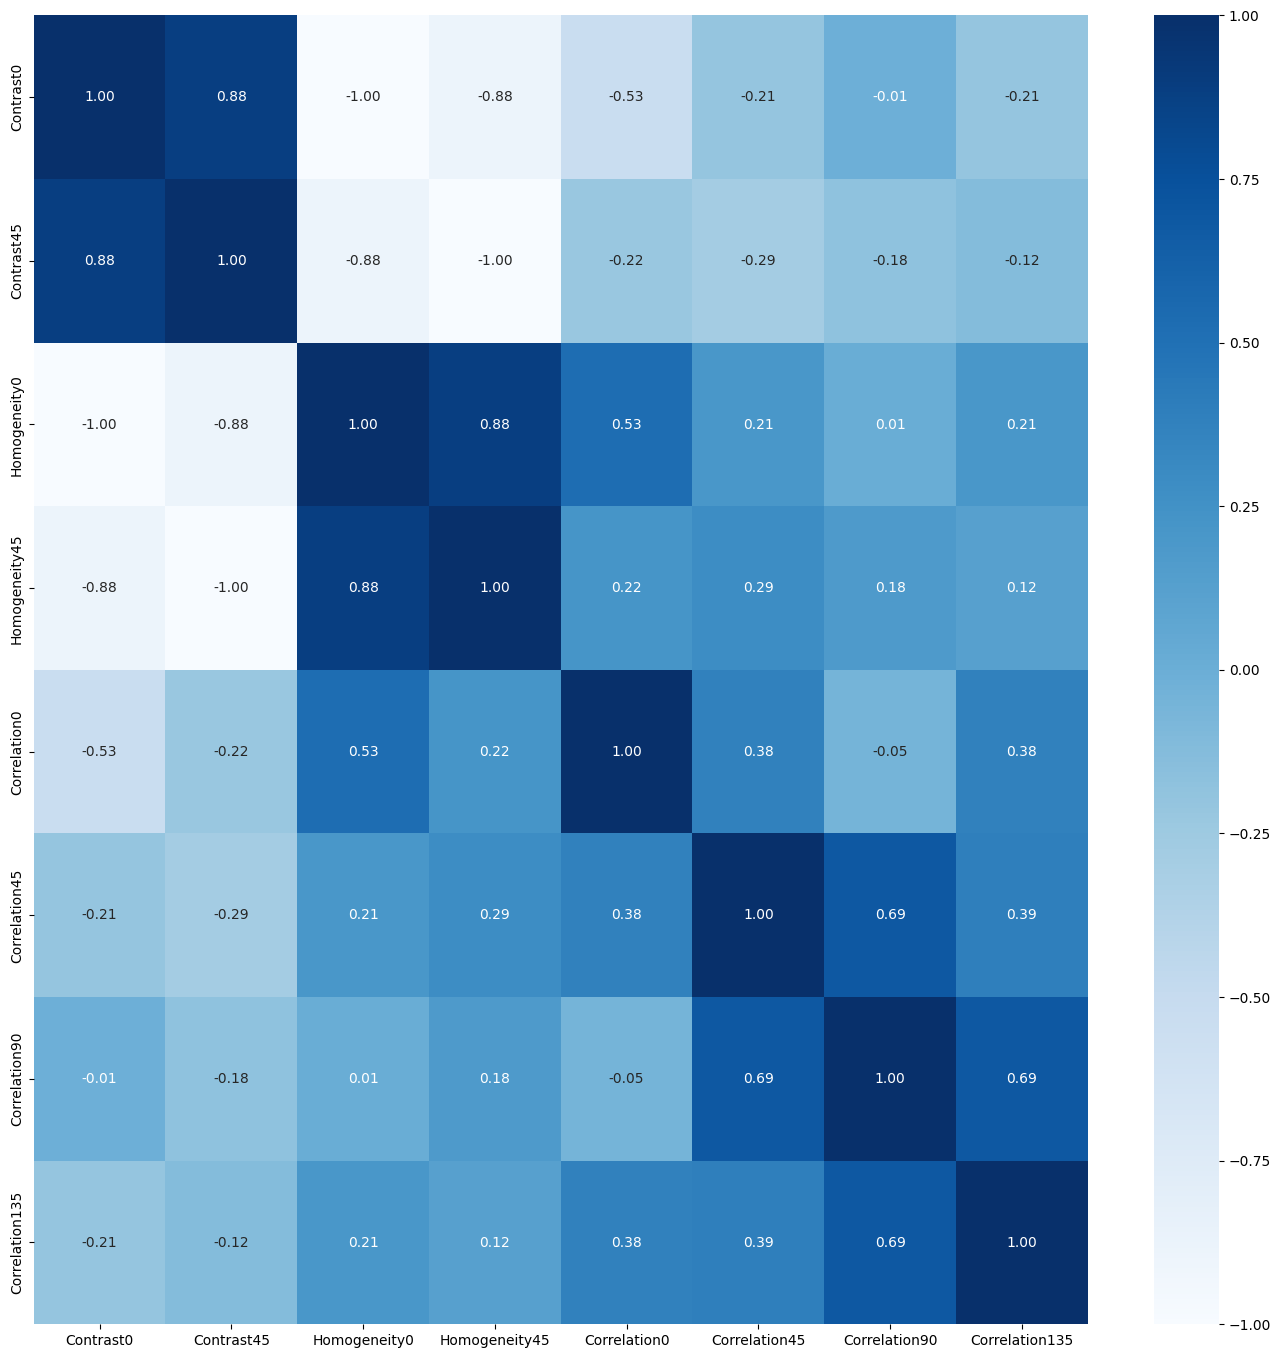

In [107]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [108]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(280, 8)
(120, 8)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [109]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [110]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [111]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       Clean       0.97      0.97      0.97       133
       Dirty       0.97      0.97      0.97       147

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280

[[129   4]
 [  4 143]]
Accuracy: 0.9714285714285714

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.81      0.82      0.81        67
       Dirty       0.77      0.75      0.76        53

    accuracy                           0.79       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.79      0.79      0.79       120

[[55 12]
 [13 40]]
Accuracy: 0.7916666666666666


### Train SVM Classifier

In [112]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       Clean       0.79      0.78      0.78       133
       Dirty       0.80      0.81      0.81       147

    accuracy                           0.80       280
   macro avg       0.80      0.80      0.80       280
weighted avg       0.80      0.80      0.80       280

[[104  29]
 [ 28 119]]
Accuracy: 0.7964285714285714

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.79      0.72      0.75        67
       Dirty       0.68      0.75      0.71        53

    accuracy                           0.73       120
   macro avg       0.73      0.74      0.73       120
weighted avg       0.74      0.73      0.73       120

[[48 19]
 [13 40]]
Accuracy: 0.7333333333333333


### Train KNN Classifier

In [113]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       Clean       0.87      0.74      0.80       133
       Dirty       0.80      0.90      0.84       147

    accuracy                           0.82       280
   macro avg       0.83      0.82      0.82       280
weighted avg       0.83      0.82      0.82       280

[[ 99  34]
 [ 15 132]]
Accuracy: 0.825

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.74      0.55      0.63        67
       Dirty       0.57      0.75      0.65        53

    accuracy                           0.64       120
   macro avg       0.66      0.65      0.64       120
weighted avg       0.67      0.64      0.64       120

[[37 30]
 [13 40]]
Accuracy: 0.6416666666666667


## Evaluation With Confusion Matrix

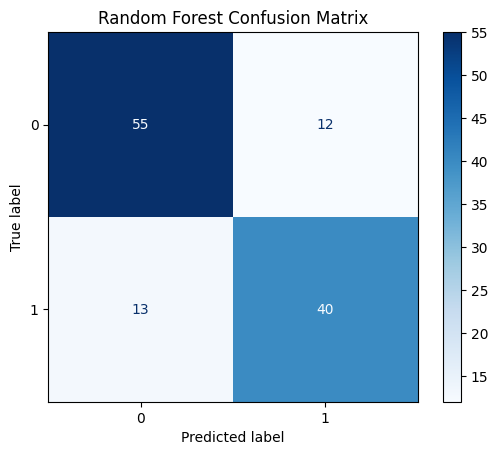

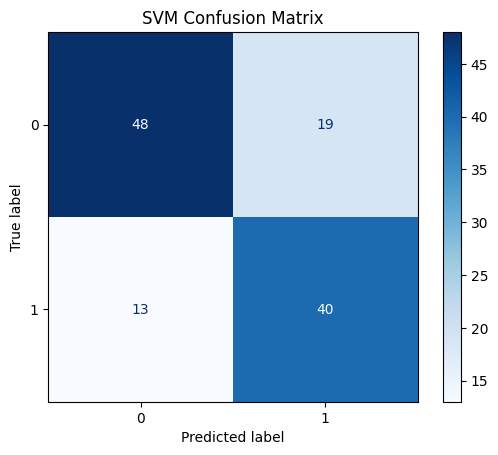

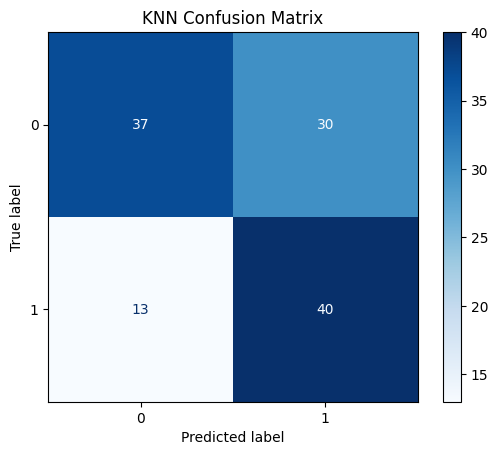

In [114]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")